<center><b> Residual Neural Network (ResNet) </b></center>

Developmed by Microsoft research team in 2015
Top-5 error rate of 3.57%

   

The codes in this notebook are from the book "Deep Leaning for Vision Systems" by **Mohamed Elgendy** I recommend this book as Mohamed does a great job in explaining the bases of each model as well as provide the code in a very simple manner.

Implementing Skip Connection: 

In [ ]:
# do all the imports 

In [ ]:
X_shortcut = X # store the value of shortcut

# the main path:
X=Conv2D(filters = F1, kernel_size = (3,3), strides=(1,1))(X)
X=Activation('relu')(X)
X=Conv2D(filters = F1, kernel_size = (3,3), strides = (1,1))(X)

#add up both paths 
X = Add()([X, X_shortcut])

#Apply relu 
X = Activation('relu')(X)

In [ ]:
def bottleneck_residual_block(X, kernel_size, filtres, reduce=False, s=2):
    F1, F2, F3 = filters # unpacks the tuple to retrieve the filters of each CN layer
    
    x_shortcut = X # save for later when adding to the main path
    
    if reduce: 
        # applying 1x1 convolutional layer to shortcut path help reduce spatial size using same stride size 
        X_shortcut = Conv2D(filters = F3, kernel_size= (1,1), strides=(s,s))(x_shortcut)
        
        x_shortcut = BatchNormalization(axis=3)(x_shortcut)
        
        x = Conv2D(filters = F1, kernel_size= (1,1), strides = (s,s), padding = 'valid')(X)    
        x = BatchNormalization(axis = 3)(x)
        x=Activation('relu')(x)
        
    else:
        # first component of main path 
        x = Conv2D(filters = F1, kernel_size = kernel_size, strides = (1,1), padding = 'valid')(x)
        x= BatchNormalization(axis=3)(x)
        x=Activation('relu')(x)
        
        # second compoenet of the  main path 
        x = Conv2D(filters = F2, kernel_size = kernel_size, strides = (1,1), padding = 'same')(x)
        x= BatchNormalization(axis=3)(x)
        x=Activation('relu')(x)
        
        # third compoenent of main path 
        x = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid')(x)
        x= BatchNormalization(axis=3)(x)
        x=Activation('relu')(x)
        
        # final step
        x = Add()([x, x_shortcut])
        x = Activaiton('relu')(x)
        
        return x

 The following table for several ResNet variations taken from "Resnet18 Model With Sequential Layer For Computing Accuracy On Image Classification Datas"

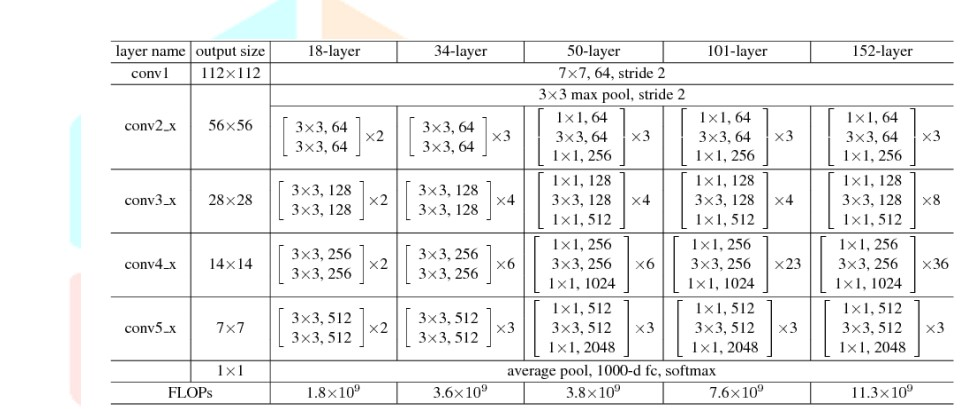

In [ ]:
def ResNet50 (input_shape, classes):
    x_input = Input(input_shape) # Defines the input as a tensor with shape input_shape
    
    #stage 1:
    x=Conv2D(64, (7,7), strides=(2,2), name='conv1')(x_input)
    x=BatchNormalization(axis=3, name='bn_conv1')(x)
    x=Activation('relu')(x)
    x=Maxpooling2D((3,3), strides=(2,2))(x)
    
    # stage 2:
    x = bottleneck_residual_block(x, 3, [64, 64, 256], reduce=True, s=1)
    x = bottleneck_residual_block(x, 3, [64, 64, 256])
    x = bottleneck_residual_block(x, 3, [64, 64, 256])
    
    # stage 3:
    x = bottleneck_residual_block(x, 3, [128, 128, 512], reduce=True, s=2)
    x = bottleneck_residual_block(x, 3, [128, 128, 512])
    x = bottleneck_residual_block(x, 3, [128, 128, 512])
    x = bottleneck_residual_block(x, 3, [128, 128, 512])
    
    
    # stage 4:
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], reduce=True, s=2)
    x = bottleneck_residual_block(x, 3, [256, 256, 1024])
    x = bottleneck_residual_block(x, 3, [256, 256, 1024])
    x = bottleneck_residual_block(x, 3, [256, 256, 1024])
    x = bottleneck_residual_block(x, 3, [256, 256, 1024])
    x = bottleneck_residual_block(x, 3, [256, 256, 1024])
    
    # stage 5:
    x = bottleneck_residual_block(x, 3, [512, 512, 2048], reduce=True, s=2)
    x = bottleneck_residual_block(x, 3, [[512, 512, 2048]])
    x = bottleneck_residual_block(x, 3, [[512, 512, 2048]])
    
    # AvgPool
    x = AveagePooling2D((1,1))(x)
    # output layer
    
    x = Flatten()(x)
    x=Dense(classes, activation='softmax', name='fc' + str(classes))(x)
    
    #create the model 
    model = Model(inputs = x_inputs = x, name='ResNet50')
    
    return model 

        
    
    

In [ ]:
from keras.callbacks import ReduceLROnPlateau

# set the training parameters
epochs = 200
batch_size = 256

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, min_lr=0.5e-6)
# min_lr is the lower bound on the learning rate

In [ ]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])

In [ ]:
# fit the model
model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=epochs, callbacks=[reduce_lr])
# train teh model, calling the reduce_lr value using callbacks in the training method 